In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                #transforms.RandomRotation((-10.0, 10.0)),
                                transforms.RandomHorizontalFlip()
                                ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck   car   cat truck   cat



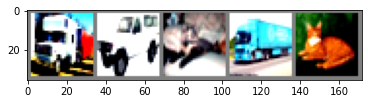

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# # functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(16, 16, 3, groups=1, dilation=2, padding=2, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU(),
                      nn.Dropout(0.05))

        # Transition 1
        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(32, 32, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.Dropout(0.1))

        # Transition 2
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.conv5 = nn.Sequential(nn.Conv2d(32, 64, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(64, 64, 3, groups=1, dilation=1, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Dropout(0.15))

        # Transition 3
        self.pool3 = nn.MaxPool2d(2, 2) 
        self.conv7 = nn.Sequential(nn.Conv2d(64, 64, 3, groups=64, dilation=1, padding=1, bias=False),
                                    nn.Conv2d(64, 128, 1, groups=1, dilation=1, bias=False),                                 
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(128, 128, 3, groups=128, dilation=1, padding=1, bias=False),
                                    nn.Conv2d(128, 128, 1, groups=1, dilation=1, bias=False),                                 
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        # GAP
        self.gap = nn.AvgPool2d(kernel_size=(4,4))
        self.conv9 = nn.Sequential(nn.Conv2d(128, 10, 1, padding=0, bias=False)) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.pool3(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = self.gap(x)
        x = self.conv9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


net = Net()

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
           Dropout-7           [-1, 16, 32, 32]               0
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,608
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]           9,216
      BatchNorm2d-13           [-1, 32, 16, 16]              64
             ReLU-14           [-1

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov = True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(trainloader), epochs=EPOCHS)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
from tqdm import tqdm

def train(model, device, train_loader, criterion, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  lambda_l1 = 0.005
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    # l1 = 0
    # for p in model.parameters():
    #   l1 = l1 + p.abs().sum()
    # loss = loss + lambda_l1 * l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    pbar.set_description(desc= pbar_str)


def test(model, device, test_loader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    
    return test_loss, test_accs, misclassified_imgs

In [14]:
test_losses = []
test_accs = []
misclassified_imgs = []
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, trainloader, criterion, optimizer, epoch)
  test_loss, test_accs, misclassified_imgs = test(model, device, testloader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch)
  scheduler.step(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.9723126292228699 Batch_id=390 Accuracy=47.68: 100%|██████████| 391/391 [00:14<00:00, 27.34it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 5834/10000 (58.34%)

EPOCH: 1


Loss=0.9142376780509949 Batch_id=390 Accuracy=65.29: 100%|██████████| 391/391 [00:14<00:00, 27.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0096, Accuracy: 5793/10000 (57.93%)

EPOCH: 2


Loss=0.8036713600158691 Batch_id=390 Accuracy=71.04: 100%|██████████| 391/391 [00:14<00:00, 27.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 6945/10000 (69.45%)

EPOCH: 3


Loss=0.6108745336532593 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:14<00:00, 27.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 7112/10000 (71.12%)

EPOCH: 4


Loss=0.8569462895393372 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:14<00:00, 27.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 6814/10000 (68.14%)

EPOCH: 5


Loss=0.7609021067619324 Batch_id=390 Accuracy=76.84: 100%|██████████| 391/391 [00:14<00:00, 27.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0068, Accuracy: 6950/10000 (69.50%)

EPOCH: 6


Loss=0.7216528058052063 Batch_id=390 Accuracy=77.47: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7402/10000 (74.02%)

EPOCH: 7


Loss=0.7346170544624329 Batch_id=390 Accuracy=78.33: 100%|██████████| 391/391 [00:14<00:00, 27.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0066, Accuracy: 7074/10000 (70.74%)

EPOCH: 8


Loss=0.6073942184448242 Batch_id=390 Accuracy=78.85: 100%|██████████| 391/391 [00:14<00:00, 27.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7428/10000 (74.28%)

EPOCH: 9


Loss=0.6486685872077942 Batch_id=390 Accuracy=79.57: 100%|██████████| 391/391 [00:14<00:00, 27.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7677/10000 (76.77%)

EPOCH: 10


Loss=0.6742733716964722 Batch_id=390 Accuracy=79.86: 100%|██████████| 391/391 [00:14<00:00, 27.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0067, Accuracy: 7100/10000 (71.00%)

EPOCH: 11


Loss=0.46661242842674255 Batch_id=390 Accuracy=79.95: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7616/10000 (76.16%)

EPOCH: 12


Loss=0.5868909358978271 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:14<00:00, 27.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0062, Accuracy: 7461/10000 (74.61%)

EPOCH: 13


Loss=0.452331006526947 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [00:14<00:00, 27.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7540/10000 (75.40%)

EPOCH: 14


Loss=0.6072075366973877 Batch_id=390 Accuracy=80.90: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 7667/10000 (76.67%)

EPOCH: 15


Loss=0.43006181716918945 Batch_id=390 Accuracy=81.14: 100%|██████████| 391/391 [00:14<00:00, 27.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7567/10000 (75.67%)

EPOCH: 16


Loss=0.45468515157699585 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:14<00:00, 27.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0057, Accuracy: 7547/10000 (75.47%)

EPOCH: 17


Loss=0.8986236453056335 Batch_id=390 Accuracy=81.33: 100%|██████████| 391/391 [00:14<00:00, 27.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7631/10000 (76.31%)

EPOCH: 18


Loss=0.5195117592811584 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 6666/10000 (66.66%)

EPOCH: 19


Loss=0.6723041534423828 Batch_id=390 Accuracy=81.94: 100%|██████████| 391/391 [00:14<00:00, 27.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7826/10000 (78.26%)

EPOCH: 20


Loss=0.5645023584365845 Batch_id=390 Accuracy=81.91: 100%|██████████| 391/391 [00:13<00:00, 28.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0060, Accuracy: 7409/10000 (74.09%)

EPOCH: 21


Loss=0.38393837213516235 Batch_id=390 Accuracy=81.77: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7594/10000 (75.94%)

EPOCH: 22


Loss=0.5399287343025208 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 7155/10000 (71.55%)

EPOCH: 23


Loss=0.3266611099243164 Batch_id=390 Accuracy=81.99: 100%|██████████| 391/391 [00:14<00:00, 27.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7713/10000 (77.13%)

EPOCH: 24


Loss=0.3415750563144684 Batch_id=390 Accuracy=82.42: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7736/10000 (77.36%)

EPOCH: 25


Loss=0.5940634608268738 Batch_id=390 Accuracy=82.37: 100%|██████████| 391/391 [00:14<00:00, 27.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7819/10000 (78.19%)

EPOCH: 26


Loss=0.42816925048828125 Batch_id=390 Accuracy=82.29: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7498/10000 (74.98%)

EPOCH: 27


Loss=0.46697765588760376 Batch_id=390 Accuracy=82.52: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7650/10000 (76.50%)

EPOCH: 28


Loss=0.6424641609191895 Batch_id=390 Accuracy=82.06: 100%|██████████| 391/391 [00:13<00:00, 27.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 6844/10000 (68.44%)

EPOCH: 29


Loss=0.5047457814216614 Batch_id=390 Accuracy=82.75: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 7739/10000 (77.39%)

EPOCH: 30


Loss=0.5504122972488403 Batch_id=390 Accuracy=82.72: 100%|██████████| 391/391 [00:13<00:00, 28.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7744/10000 (77.44%)

EPOCH: 31


Loss=0.5927258133888245 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 6758/10000 (67.58%)

EPOCH: 32


Loss=0.5927670001983643 Batch_id=390 Accuracy=82.85: 100%|██████████| 391/391 [00:14<00:00, 27.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7580/10000 (75.80%)

EPOCH: 33


Loss=0.6700566411018372 Batch_id=390 Accuracy=82.62: 100%|██████████| 391/391 [00:14<00:00, 27.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7577/10000 (75.77%)

EPOCH: 34


Loss=0.6811597347259521 Batch_id=390 Accuracy=82.74: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7883/10000 (78.83%)

EPOCH: 35


Loss=0.4526668190956116 Batch_id=390 Accuracy=83.00: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7750/10000 (77.50%)

EPOCH: 36


Loss=0.7704634070396423 Batch_id=390 Accuracy=82.96: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7552/10000 (75.52%)

EPOCH: 37


Loss=0.511177659034729 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [00:14<00:00, 27.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 7970/10000 (79.70%)

EPOCH: 38


Loss=0.5108054876327515 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:14<00:00, 27.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7606/10000 (76.06%)

EPOCH: 39


Loss=0.5447386503219604 Batch_id=390 Accuracy=83.06: 100%|██████████| 391/391 [00:14<00:00, 26.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0059, Accuracy: 7467/10000 (74.67%)

EPOCH: 40


Loss=0.31497982144355774 Batch_id=390 Accuracy=83.18: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8072/10000 (80.72%)

EPOCH: 41


Loss=0.5726691484451294 Batch_id=390 Accuracy=83.13: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7920/10000 (79.20%)

EPOCH: 42


Loss=0.313681423664093 Batch_id=390 Accuracy=83.14: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7645/10000 (76.45%)

EPOCH: 43


Loss=0.42512768507003784 Batch_id=390 Accuracy=83.09: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7899/10000 (78.99%)

EPOCH: 44


Loss=0.4812679886817932 Batch_id=390 Accuracy=83.24: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7753/10000 (77.53%)

EPOCH: 45


Loss=0.4618651270866394 Batch_id=390 Accuracy=83.42: 100%|██████████| 391/391 [00:13<00:00, 27.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7769/10000 (77.69%)

EPOCH: 46


Loss=0.6561985611915588 Batch_id=390 Accuracy=83.36: 100%|██████████| 391/391 [00:14<00:00, 27.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7859/10000 (78.59%)

EPOCH: 47


Loss=0.7783482074737549 Batch_id=390 Accuracy=83.33: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7596/10000 (75.96%)

EPOCH: 48


Loss=0.5471516847610474 Batch_id=390 Accuracy=83.23: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7742/10000 (77.42%)

EPOCH: 49


Loss=0.39162176847457886 Batch_id=390 Accuracy=83.41: 100%|██████████| 391/391 [00:13<00:00, 28.02it/s]


Test set: Average loss: 0.0053, Accuracy: 7692/10000 (76.92%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [15]:
def classwise(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

classwise(model, device, testloader, classes)

Accuracy of plane : 65 %
Accuracy of   car : 85 %
Accuracy of  bird : 84 %
Accuracy of   cat : 55 %
Accuracy of  deer : 77 %
Accuracy of   dog : 57 %
Accuracy of  frog : 88 %
Accuracy of horse : 60 %
Accuracy of  ship : 96 %
Accuracy of truck : 79 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


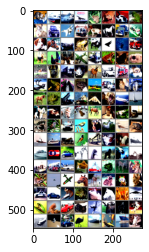

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [17]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse horse   dog  bird


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 11 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird : 42 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog : 18 %
Accuracy of  frog :  0 %
Accuracy of horse : 28 %
Accuracy of  ship : 18 %
Accuracy of truck :  0 %
